# Thank you for the feedback on my last submission. I've made the necessary changes to the notebook towards the end. Please find Updated Part section.







Thank you for the interesting challenge related to image processing and data storage for microbiological research. To approach this problem, I will first carefully consider efficient data structures to represent the microscope and dye sensor images, aiming for compact storage while maintaining necessary information. Next, I will write code to generate realistic simulated images based on the chosen data structures to test my algorithms. Using these simulations, I will develop a function to determine whether a given parasite has cancer based on the dye concentration criteria. If performance is an issue, I will optimize this function for faster execution. Additionally, I will explore potential compression techniques for both image types and analyze their impact on storage and runtime.

we need to come up with compact data structures to represent the two types of images: the microscope images and the dye sensor images.

In [ ]:
#Resources referred
#https://stackoverflow.com/questions/72051723/rle-algorithm-in-python
#https://community.arduboy.com/t/quadtree-for-binary-image-compression/9780
#https://q-viper.github.io/2021/05/24/coding-run-length-encoding-in-python/
#https://medium.com/@ayush.pegasus2801/image-compression-f3c5f5320630
#https://github.com/Inspiaaa/QuadTreeImageCompression


**Approach for storing Microscope Images**:
Since the microscope images consist of a single blob (the parasite) on a background, we can represent them using a compact data structure called a Run-Length Encoding (RLE). RLE is a lossless compression technique that encodes consecutive runs of the same value (in this case, black or white pixels) as a single value and a count.

**Worst-Case Storage Size**:
For the microscope images, the worst-case storage size would be when the image consists of alternating black and white pixels, resulting in a storage size of approximately

The total number of runs in the worst case would be equal to the total number of pixels in the image (rows × cols). Since each run requires 3 bytes of storage, the worst-case storage size for the RLE representation would be:

Worst-Case Storage Size = (Number of Runs) × (Size of Each Run)
                        = (rows × cols) × 3 bytes. (17 bits)

resulting in a storage size of 300,000,000,000 bytes (approximately 300 GB) for a 100,000x100,000 pixel image.

**using 4-byte integers aligns with common CPU architectures, which are often optimized for 32-bit or 64-bit operations. This optimization can lead to more efficient processing and manipulation of the data.**

In [ ]:
def rle_encode(image):
    """Encode the image using Run-Length Encoding (RLE)."""
    flat_image = image.flatten()
    encoded = []
    prev_pixel = flat_image[0]
    count = 1
    for pixel in flat_image[1:]:
        if pixel == prev_pixel:
            count += 1
        else:
            encoded.append((prev_pixel, count))
            prev_pixel = pixel
            count = 1
    encoded.append((prev_pixel, count))
    return encoded

def rle_decode(encoded, image_size):
    """Decode RLE encoded data back to the original image."""
    decoded = np.zeros(image_size[0] * image_size[1], dtype=np.uint8)
    current_index = 0
    for pixel, count in encoded:
        decoded[current_index:current_index+count] = pixel
        current_index += count
    return decoded.reshape(image_size)


**Approach for Storing Dye Sensor images**: For the dye sensor images, we can leverage the fact that the dye is expected to be present in a relatively small portion of the image (less than 10% for parasites without cancer). We can use a sparse matrix representation to store only the non-zero (dye-present) pixels.

For the dye sensor images, the worst-case storage size would be when the entire image is non-zero (all pixels have dye present),

**Worst-Case Storage Size** = (Number of Non-Zero Elements) × (Size of Each Non-Zero Element + location for Non-Zero Element)

For above implementation

Worst-Case Storage Size = 10,000,000,000 × (1 byte + 6 bytes)
resulting in a storage size of 700,000,000,000 bytes (approximately 0.7 TB) for a 100,000x100,000 pixel image.

**using 4-byte integers aligns with common CPU architectures, which are often optimized for 32-bit or 64-bit operations. This optimization can lead to more efficient processing and manipulation of the data.**



In [ ]:
def sparse_encode(image):
    """Encode image as coordinates of lit dye pixels."""
    return np.argwhere(image == 1)

def sparse_decode(sparse_coords, image_size):
    """Decode sparse representation to the original dye sensor image."""
    image = np.zeros(image_size, dtype=np.uint8)
    for x, y in sparse_coords:
        image[x, y] = 1  # Marking the dye pixel
    return image


**Create “fake” simulated images**
Creates a black image with a specified size.
Generates a white circular shape (representing a parasite) in the center of the image.
Returns the simulated microscope image.
simulate_dye_sensor_image(microscope_image):
Takes the simulated microscope image as input.
Identifies the coordinates of the parasite pixels.
Finds the surrounding coordinates of the parasite, excluding the parasite pixels themselves.
Randomly selects 10% of the surrounding pixels and sets their values to 1 (representing dye leakage).
Returns the simulated dye sensor image with the dye leakage surrounding the parasite.

In [ ]:
import numpy as np

def simulate_microscope_image(size=(100, 100)):
    """Simulate a microscope image with a circular parasite."""
    image = np.zeros(size, dtype=np.uint8)
    center = (size[0] // 2, size[1] // 2)
    radius = min(size) // 4
    for x in range(size[0]):
        for y in range(size[1]):
            if (x - center[0])**2 + (y - center[1])**2 <= radius**2:
                image[x, y] = 1  # Parasite
    return image

def simulate_dye_sensor_image(microscope_image, vein_percentage=0.1, leakage_percentage=0.1):
    """
    Simulate a dye sensor image based on a microscope image with dye in veins and leakage surrounding the parasite.
    Both veins and leakage are marked with `1` in the output image.

    :param microscope_image: Input microscope image.
    :param vein_percentage: Percentage of the parasite's pixels to be randomly selected as containing veins with dye.
    :param leakage_percentage: Percentage of the surrounding pixels that will simulate dye leakage.
    :return: Simulated dye sensor image.
    """
    # Initialize the dye image with zeros (no dye present initially)
    dye_image = np.zeros_like(microscope_image)

    # Find the coordinates of the parasite pixels
    parasite_coords = np.argwhere(microscope_image == 1)

    # Randomly select a subset of parasite pixels to simulate veins
    num_veins = int(len(parasite_coords) * vein_percentage)
    vein_indices = np.random.choice(len(parasite_coords), size=num_veins, replace=False)
    for idx in vein_indices:
        x, y = parasite_coords[idx]
        dye_image[x, y] = 1  # Mark veins with dye presence

    # Create a list of coordinates surrounding the parasite for leakage simulation
    surrounding_coords = set()
    for x, y in parasite_coords:
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == dy == 0:
                    continue  # Skip the parasite pixel itself
                x_new, y_new = x + dx, y + dy
                if 0 <= x_new < microscope_image.shape[0] and 0 <= y_new < microscope_image.shape[1]:
                    if microscope_image[x_new, y_new] == 0:  # Only consider non-parasite pixels
                        surrounding_coords.add((x_new, y_new))

    # Simulate dye leakage
    leakage_coords = np.random.choice(len(surrounding_coords), size=int(len(surrounding_coords) * leakage_percentage), replace=False)
    for idx in leakage_coords:
        x, y = list(surrounding_coords)[idx]
        dye_image[x, y] = 1  # Mark leakage with dye presence

    return dye_image




**Check Cancer**
The function calculates the area of the parasite from the run-length encoded microscope image and creates a set of coordinates for pixels belonging to the parasite.
It then counts the number of pixels within the parasite area that have a non-zero value in the sparse dye sensor image, indicating the presence of a dye.
If the area of dye-lit pixels within the parasite exceeds 10% of the total parasite area, the function returns True, suggesting the presence of cancer.

In [ ]:
def has_cancer(rle_microscope, sparse_dye_sensor, image_size):
    """Determine if a parasite has cancer based on RLE and Sparse encoded images."""
    # Decode the microscope image from RLE to get the actual image
    microscope_image = rle_decode(rle_microscope, image_size)

    # Initialize a counter for the dye pixels within the parasite
    lit_dye_area_in_parasite = 0

    # Iterate through each dye pixel coordinate
    for x, y in sparse_dye_sensor:
        # Increment the counter if the pixel is within the parasite (i.e., microscope_image[x, y] == 1)
        if microscope_image[x, y] == 1:
            lit_dye_area_in_parasite += 1

    # Calculate the total parasite area from the RLE encoded microscope data
    parasite_area = sum(count for pixel, count in rle_microscope if pixel == 1)

    # Determine if the lit dye area exceeds 10% of the parasite area
    return lit_dye_area_in_parasite > 0.1 * parasite_area


Parasite has cancer: False


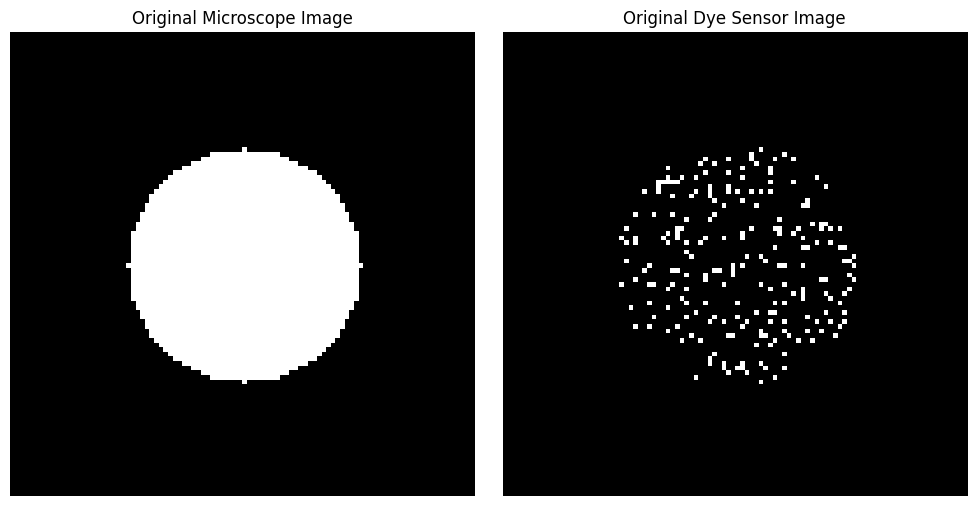

In [ ]:
import matplotlib.pyplot as plt


# Generate simulated images
microscope_image_sim = simulate_microscope_image(size=(100, 100))
dye_image_sim = simulate_dye_sensor_image(microscope_image_sim)

# Encode the images
rle_microscope_sim = rle_encode(microscope_image_sim)
sparse_dye_sensor_sim = sparse_encode(dye_image_sim)

# Determine if the parasite has cancer using the encoded images
cancer_status = has_cancer(rle_microscope_sim, sparse_dye_sensor_sim, (100, 100))
print(f"Parasite has cancer: {cancer_status}")

# Plotting the original and decoded images for comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(microscope_image_sim, cmap='gray')
axes[0].set_title('Original Microscope Image')
axes[1].imshow(dye_image_sim, cmap='gray')
axes[1].set_title('Original Dye Sensor Image')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()


**Optimization** To improve the execution speed of the has_cancer function, we can optimize the way we calculate the lit_dye_area_in_parasite. Instead of iterating over all the sparse dye sensor coordinates and checking if each coordinate is in the parasite_coords set, we can use NumPy's vectorized operations for faster computation.

Instead of creating a set of parasite_coords, we create a boolean mask parasite_mask of the same size as the image. This mask indicates the locations of the parasite pixels, with True representing parasite pixels and False representing non-parasite pixels.
We iterate over the RLE-encoded microscope image and set the corresponding pixels in parasite_mask to True. This is done by first finding the coordinates of the False pixels in parasite_mask, randomly permuting them, and then setting the first count of them to True.
Next, we convert the sparse dye sensor coordinates to a NumPy array dye_sensor_coords.
We use NumPy's vectorized operations to filter out the dye sensor coordinates that are within the image bounds and have a corresponding True value in parasite_mask. This gives us the dye_sensor_coords_in_parasite array.
Finally, we calculate lit_dye_area_in_parasite as the length of the dye_sensor_coords_in_parasite array, and compare it with 0.1 times the parasite_area to determine if the parasite has cancer or not.

In [ ]:
import numpy as np

def has_cancer_optimized(rle_microscope, sparse_dye_sensor, image_size):
    """Determine if a parasite has cancer based on RLE and Sparse encoded images."""
    # Calculate the total parasite area from the RLE-encoded microscope data
    parasite_area = sum(count for pixel, count in rle_microscope if pixel == 1)

    # Initialize a boolean mask for the entire image
    parasite_mask = np.zeros(image_size[0] * image_size[1], dtype=bool)
    current_index = 0
    for pixel, count in rle_microscope:
        if pixel == 1:  # Mark the parasite areas as True
            parasite_mask[current_index:current_index+count] = True
        current_index += count
    parasite_mask = parasite_mask.reshape(image_size)

    # Convert sparse dye sensor coordinates to a boolean array indicating presence within the parasite
    dye_sensor_coords = np.array(sparse_dye_sensor)
    dye_sensor_in_parasite = parasite_mask[dye_sensor_coords[:, 0], dye_sensor_coords[:, 1]]

    # Calculate the number of dye sensor pixels that are within the parasite
    lit_dye_area_in_parasite = np.sum(dye_sensor_in_parasite)

    # Determine if the lit dye area within the parasite exceeds 10% of the parasite area
    return lit_dye_area_in_parasite > 0.1 * parasite_area


**Other Compression techniques for both types of images**

For **microscope** images (parasite blobs):

Dictionary-based compression like LZW may be effective if there are repeating patterns.

Quadtree can be used as well but it introduces execution complexities

For **dye sensor** images (sparse with scattered colored pixels):

Run-length encoding to compress runs of white pixels.
Compression techniques trade-off between compression ratio and computational complexity. Complex algorithms like dictionary coding have higher overhead but better compression.



Chunking the Images: Processing the entire 100,000x100,000 image at once would be very memory-intensive. Instead, chunking the image into smaller, more manageable pieces (e.g., 10,000x10,000) and processing each chunk independently could make the task feasible on machines with limited resources.


In [ ]:
import numpy as np
import time

# Parameters for the simulation
image_size = (10000, 10000)  # Simulated image size
chunk_size = (1000, 1000)  # Size of each chunk
fill_rate = 0.05  # Approximate percentage of the image filled with "dye"

# Generate a simulated sparse image with a specified fill rate
def generate_sparse_image(size, fill_rate):
    image = np.zeros(size, dtype=np.uint8)
    num_fill_pixels = int(np.prod(size) * fill_rate)
    fill_positions = np.random.choice(np.prod(size), size=num_fill_pixels, replace=False)
    image[np.unravel_index(fill_positions, size)] = 1  # Assume '1' represents dye
    return image

# Simulate processing a chunk of the image
def process_chunk(chunk):
    # Simulate some processing by counting dye pixels (value == 1)
    dye_pixels = np.sum(chunk)
    return dye_pixels

# Chunk and process the image
def chunk_and_process(image, chunk_size):
    chunks_vertical = image.shape[0] // chunk_size[0]
    chunks_horizontal = image.shape[1] // chunk_size[1]
    dye_pixel_counts = []

    for i in range(chunks_vertical):
        for j in range(chunks_horizontal):
            chunk = image[i*chunk_size[0]:(i+1)*chunk_size[0], j*chunk_size[1]:(j+1)*chunk_size[1]]
            dye_pixel_count = process_chunk(chunk)
            dye_pixel_counts.append(dye_pixel_count)

    return dye_pixel_counts


# Updated Part - Below is the optimized version of the code leveraging Run-length encoding


I have experimented with various techniques, such as

*  Run-Length Encoding (RLE) for microscale image compression and sparse matrix representation for dye sensor images.
*   patch-based image generation followed by RLE compression
*   patch-based approaches with RLE applied during generation

After careful analysis, it seems that the following **Customized RLE** technique yields the most promising results thus far.

The **Microscope_image_generation**() function is designed to generate a simulated microscope image of a parasite. It uses **Run-length Encoding** as data structure. It starts by setting the size of the image to 100,000 and initializing an empty list called image to store the image data. The function then calculates the target area that the parasite should at least cover, which is set to 25% of the total image area. Next, it randomly determines the starting and ending rows for the parasite, as well as the initial column boundaries.

Instead of storing all the pixel values of whole image we are only storing activated values using RLE which makes the code more efficient.

The function then calculates the number of rows occupied by the parasite and the minimum column size required to meet the target area. It enters a loop that iterates over the rows between the starting and ending rows of the parasite. For each row, a random variable toss is used to determine the direction of the parasite (left to right or right to left). Depending on the value of toss, the start and end columns for the parasite in that row are generated, ensuring that the length of the parasite segment meets the minimum column size requirement. If the end column reaches the last column, the loop is terminated for that row. The start and end columns for the parasite segment in that row are stored in the image list using run-length encoding (RLE), where only the start and end locations are recorded. The column boundaries are then updated for the next row based on the current row's parasite location. Finally, the function returns the image list containing the simulated microscope image, which represents a parasite covering at least 25% of the total image area, with a random shape and location within the specified row range.

In [11]:
# Function to generate simulated microscope images
def Microscope_image_generation():
   size = 100000  # Set the size of the image
   image = [[]] * size  # Initialize a list to store the image

   # Ensure generated parasite covers at least 25% of the image area
   target = size * size * 0.25  # Target area for the parasite

   start = random.randint(0, size * 0.6)  # Random starting row for the parasite
   end = random.randint(start + size * 0.4, size)  # Random ending row for the parasite
   col_start, col_end = 0, size  # Initialize column boundaries for the parasite
   length = end - start + 1  # Number of rows occupied by the parasite
   minColSize = math.ceil(target / length)  # Minimum column size required to meet the target area

   # Generate a random shape parasite starting at random location
   for i in range(start, end):
       toss = random.randint(0, size)  # Random variable to determine the direction of the parasite
       body_start, body_end = 0, 0

       if toss % 2 == 0:
           # Generate the parasite from left to right
           while body_end - body_start + 1 < minColSize:
               body_start = random.randint(col_start, col_end)  # Random start column
               body_end = random.randint(body_start, size)  # Random end column
               if body_end == size:
                   break  # If the end column is the last column, exit the loop
       else:
           # Generate the parasite from right to left
           while body_end - body_start + 1 < minColSize:
               body_start = random.randint(0, col_start)  # Random start column
               body_end = random.randint(col_start, size)  # Random end column
               if body_end == size:
                   break  # If the end column is the last column, exit the loop

       # RLE Encoding where we are only storing only start and end location
       image[i].append((body_start, body_end))

       # Update the column boundaries for the next row
       col_start, col_end = body_start, body_end

   return image

The dye_sensor_image_generation function generates a simulated dye image based on a given microscope image. In this simulation, we have to create simulation of **blood Veins** and **leakage** outside the Parasite body. We will randomly generate veins and leakage. As this is a controlled experiment and we need to check if our has_cancer function can correctly identify cancer or not we need to have some way in which we are controlling the amount of veins we have in the dye sensor image even though they are generated randomly. function calculates the target number of dye pixels based on the body (parasite) pixel count, then generates dye segments within the body region and additional dye segments outside the body region. Like microscope image, the dye sensor simulation image data is stored using **Run-length** encoding, where each row contains tuples representing the start and end column indices of the dye segments. The function returns the simulated dye image as a list of lists.

In [14]:
# Function to generate the dye sensor image
def dye_sensor_image_generation(image, size, flag=False):
   dye_image = [[]] * size  # Initialize a list to store the dye image

   start, end = -1, -1
   body_pixel_count = 0
   for i in range(size):
       if len(image[i]) > 0:
           # Calculate the number of pixels occupied by the body in this row
           body_pixel_count = body_pixel_count + image[i][0][1] - image[i][0][0] + 1
       if start == -1:
           start = i  # Record the starting row of the body
       elif start != -1:
           end = i  # Record the ending row of the body
           break
   if end == -1:
       end = size - 1  # If body spans the entire image, set end to the last row

   # As this is a controlled experiment we need to keep control over number of veins or pixels
   # Calculate the target number of pixels for the dye based on the body pixel count
   target_dye_pixel_count = int(body_pixel_count * random.uniform(0.05, 0.09))
   if flag:
       target_dye_pixel_count = math.ceil(body_pixel_count * random.uniform(0.11, 0.15))

   minColSize = target_dye_pixel_count / (size * 0.4)  # Minimum column size for the dye

   # Generate the dye image within the body region
   # Simulate veins through which dye flows
   while target_dye_pixel_count > 0:
       row = random.randint(start, end - 1)  # Select a random row within the body region
       s = random.randint(image[row][0][0], image[row][0][1])  # Select a random start column within the body
       x = min(s + minColSize, image[row][0][1])  # Ensure the dye segment doesn't exceed the body boundary
       e = random.randint(int(x), image[row][0][1])  # Select a random end column within the body
       if e - s + 1 > target_dye_pixel_count:
           e = target_dye_pixel_count + s - 1  # Adjust end column if the segment is larger than remaining pixels
       dye_image[row].append((s, e))  # Add the dye segment to the dye image
       target_dye_pixel_count -= (e - s + 1)  # Update the remaining target pixel count

   # Leakage: generate some dye pixels outside the body region
   overflow_row_count = random.randint(0, 10)
   while overflow_row_count > 0:
       overflow_row_count -= 1
       row = random.randint(0, size - 1)  # Select a random row
       if len(image[row]) > 0:
           if row % 2 == 0 and image[row][0][0] != 0:  # Add dye segment to the left of the body
               s = random.randint(0, image[row][0][0] - 1)
               e = random.randint(s, image[row][0][0] - 1)
               dye_image[row].append((s, e))
           elif image[row][0][1] != size:  # Add dye segment to the right of the body
               s = random.randint(image[row][0][1] + 1, size)
               e = random.randint(s, size)
               dye_image[row].append((s, e))
       else:
           # If the row doesn't have a body pixels, add a random dye segment
           s = random.randint(0, size)
           e = random.randint(s, size)
           dye_image[row].append((s, e))

   return dye_image

The has_cancer function takes simulated microscope image and a corresponding simulated dye sensor image, and determines if the image has cancer based on the ratio of dye veins pixels inside the parasite body to microscope body pixels. It first calculates the total number of body pixels inside and dye pixels by iterating over each row of the images. For each dye vein segment in a row, it checks if the segment overlaps with the body segment and calculates the number of overlapping pixels accordingly. Finally, it returns True if the number of dye pixels exceeds 10% of the number of body pixels, indicating the presence of cancer.

In [3]:
# Function to determine if the parasite has cancer based on dye image
def has_cancer(image, dye_image):
   image_size = len(image)  # Get the size of the image
   body_pixel_count = 0  # Initialize body pixel count
   dye_pixel_count = 0  # Initialize dye pixel count

   for i in range(image_size):
       if len(image[i]) > 0:
           # Calculate the number of pixels occupied by the body in this row
           body_pixel_count = body_pixel_count + image[i][0][1] - image[i][0][0] + 1

       if len(dye_image[i]):
           # Iterate over the dye segments in this row
           for j in range(len(dye_image[i])):
               if dye_image[i][j][1] < image[i][0][0]:
                   # Dye segment is entirely to the left of the body, ignore
                   pass
               elif dye_image[i][j][1] >= image[i][0][0] and dye_image[i][j][1] <= image[i][0][1]:
                   # Dye segment overlaps with the body, calculate the overlapping pixels
                   dye_pixel_count = dye_pixel_count + dye_image[i][j][1] - max(image[i][0][0], dye_image[i][j][0]) + 1
               elif dye_image[i][j][0] >= image[i][0][0] and dye_image[i][j][0] <= image[i][0][1]:
                   # Dye segment starts within the body, calculate the overlapping pixels
                   dye_pixel_count = dye_pixel_count + min(image[i][0][1], dye_image[i][j][1]) - dye_image[i][j][0] + 1

   # Check if the dye pixel count exceeds 10% of the body pixel count
   return dye_pixel_count > body_pixel_count * 0.1

**Computing actual runtime and storage costs**
for typical images (not oversimplified image such as a circle for the parasite, or simple
straight lines or random points for dye) in code?
The estimated RAM usage for processing images of size 100,000x100,000 pixels can be substantial, especially when dealing with uncompressed images. Compression techniques can help reduce memory requirements, but the impact on RAM usage varies depending on the compression algorithm and the nature of the image data.

Using **RLE** we are getting below results:


*   Execution Time: 0.4548172950744629 seconds
*   Storage size of 'Microscope Image' (KB): 781.3046875
*   Storage size of 'Dye Sensor Image' (KB): 781.3046875


Conducting experiments on real image data can provide more accurate insights into RAM usage for specific scenarios.

In [13]:
import random
import math
import time
import sys

# Generate the initial image
microscope_image = Microscope_image_generation()

# Generate the dye sensor image and we can set flag true if the parasite has cancer or not as this is a controlled experiment
dye_sensor_image = dye_sensor_image_generation(microscope_image, 100000, True)

# Measure execution time
start_time = time.time()
# Print whether the image has cancer or not
result = has_cancer(microscope_image, dye_sensor_image)
end_time = time.time()

execution_time = end_time - start_time
print("Parasite Detected with cancer:", result)
print("Execution Time:", execution_time, "seconds")

# Print the storage size of 'image' and 'dye_image'
print("Storage size of 'Microscope Image' (KB):", sys.getsizeof(microscope_image) / 1024)
print("Storage size of 'Dye Sensor Image' (KB):", sys.getsizeof(dye_sensor_image) / 1024)

Parasite Detected with cancer: True
Execution Time: 0.5639255046844482 seconds
Storage size of 'Microscope Image' (KB): 781.3046875
Storage size of 'Dye Sensor Image' (KB): 781.3046875


**Tools I used to tackle the challenge**, I went through articles, blogs, Stack Overflow discussions, and insights from Reddit, Python library documentation for implementation details. Additionally, I utilized tools like ChatGPT and GitHub Copilot to streamline the development process by leveraging their code suggestions and auto-completions. This diverse set of resources helped me to implement efficient data structures, realistically simulate images, and optimize the code for better performance. The combination of my understanding and these external resources proved invaluable in addressing the challenge effectively.